# Demand Forecasting from Sales Data

## Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

In [112]:
plt.rcParams["figure.figsize"] = 12,6

## Import Data and Preprocess

In [270]:
path        = "satis.xlsx"
df          = pd.read_excel(path, index_col="DateId", parse_dates=True)

# df.DateId   = pd.to_datetime(df.DateId)
# df["Month"] = df.index.dt.to_period("M")

In [271]:
first_date, last_date = df.index.min(), df.index.max()
df["DaystoLastDate"]  = (last_date - df.index).days 

columns     = ["ProductId", "ProductBasePrice", "DiscountRate", "Amount", "DaystoLastDate", "Total"]
df          = df[columns]
df.head()

,ProductId,ProductBasePrice,DiscountRate,Amount,DaystoLastDate,Total
DateId,,,,,,
2020-04-09,12555,9.52,0,960,1360,9139.20
2020-04-09,12556,12.68,0,1200,1360,15216.00
2020-04-09,12557,13.62,0,1392,1360,18959.04
2020-04-09,12558,10.22,0,816,1360,8339.52
2020-04-09,12563,23.92,0,816,1360,19518.72


In [272]:
df.describe()

,ProductId,ProductBasePrice,DiscountRate,Amount,DaystoLastDate,Total
count,440945.000000,440945.000000,440945.000000,440945.000000,440945.000000,4.409450e+05
mean,21019.605305,30.585974,3.761796,57.856984,790.246087,1.576266e+03
std,20012.552294,80.236186,8.262789,851.576862,368.344725,1.998855e+04
min,12555.000000,0.000000,0.000000,-57024.000000,0.000000,-6.610200e+05
25%,12569.000000,12.850000,0.000000,4.000000,526.000000,7.872000e+01
50%,12639.000000,19.640000,0.000000,12.000000,833.000000,2.199600e+02
75%,13479.000000,37.070000,4.000000,24.000000,1110.000000,6.598800e+02
max,84034.000000,11017.000000,198.000000,285696.000000,1360.000000,5.905440e+06


## Analyze Data

In [273]:
print(f"First sale on {first_date.date()} \nLast sale on  {last_date.date()}")
print(f"Windows is {round((last_date - first_date).days / 364, 2)} years")

First sale on 2020-04-09 
Last sale on  2023-12-30
Windows is 3.74 years


Text(0, 0.5, 'Frequency in sales data')

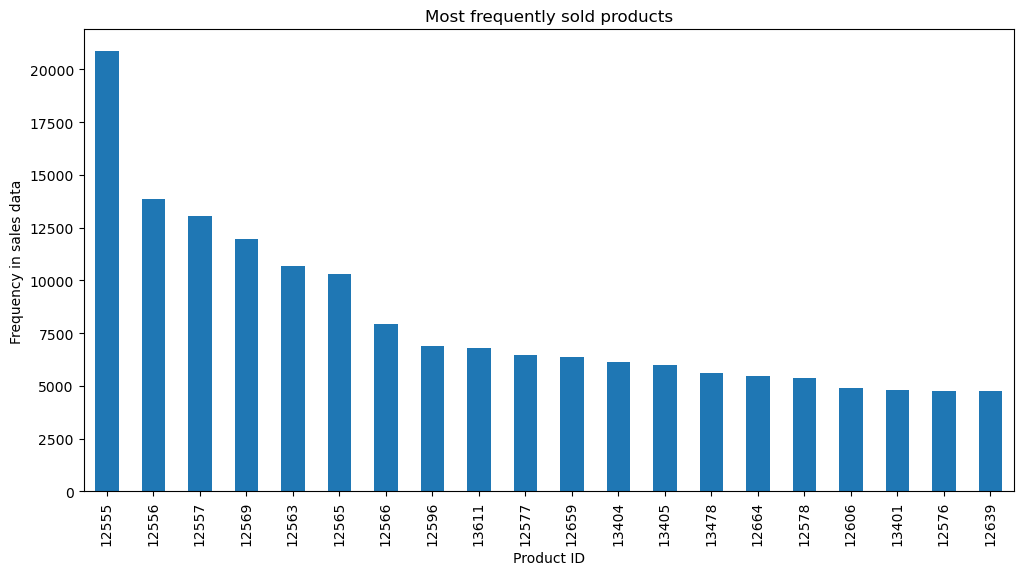

In [274]:
# Most frquently sold products

df.ProductId.value_counts().head(20).plot(kind="bar", figsize=(12, 6))
plt.title("Most frequently sold products")
plt.xlabel("Product ID")
plt.ylabel("Frequency in sales data")

## Filter eligible products

In [276]:
# Outliers
def remove_outliers_in_sales(df, z_threshold=3):
    # Calculate z-scores for each group of ProductId
    df['z_score'] = df.groupby('ProductId')['Amount'].transform(stats.zscore)

    # Filter out rows where the absolute z-score exceeds the threshold
    filtered_df = df[abs(df['z_score']) <= z_threshold].drop(columns=['z_score'])

    return filtered_df

filtered_df = remove_outliers_in_sales(df)
filtered_df.describe()

,ProductId,ProductBasePrice,DiscountRate,Amount,DaystoLastDate,Total
count,435694.000000,435694.000000,435694.000000,435694.000000,435694.000000,4.356940e+05
mean,20991.432370,30.600528,3.689000,38.008504,790.601934,1.065407e+03
std,19981.032216,80.429498,8.200962,203.203704,368.234210,7.068229e+03
min,12555.000000,0.000000,0.000000,-10368.000000,0.000000,-6.610200e+05
25%,12569.000000,12.850000,0.000000,4.000000,526.000000,7.608000e+01
50%,12639.000000,19.640000,0.000000,12.000000,834.000000,2.144000e+02
75%,13479.000000,37.070000,4.000000,24.000000,1110.000000,6.314400e+02
max,84034.000000,11017.000000,198.000000,10800.000000,1360.000000,1.258598e+06


In [277]:
inactive_threshold = 364
long_enough        = 364
min_sales          = 100
date_quantile      = .95

filtered_df["Date"] = pd.to_datetime(filtered_df.index)

product_details                                 = filtered_df.groupby("ProductId")["Date"].agg(["min", "max"])
product_details.columns                         = ["first_sale", "last_sale"]

# Date Related
product_details["days_between"]                 = (product_details["last_sale"] - product_details["first_sale"]).dt.days
product_details["days_since_last_sale"]         = (last_date - product_details.last_sale).dt.days

# Validity of the product
product_details["inactive"]                     = product_details["days_since_last_sale"].apply(lambda day: day > inactive_threshold)
product_details["sold_long_enough"]             = product_details["days_between"].apply(lambda days: days > long_enough)

# Sales volume
product_details["total_sale_amount"]            = filtered_df.groupby("ProductId")["Amount"].sum()
product_details["sale_amount_per_month"]        = product_details["total_sale_amount"] / (product_details["days_between"] / 30)

# Sales count
product_details["quantile_sales_date"]          = filtered_df.query("Amount > 0").groupby("ProductId")["Date"].agg(lambda x: x.quantile(date_quantile))
product_details["quantile_days_to_last_sale"]   = (last_date - product_details["quantile_sales_date"]).dt.days
product_details["quantile_test"]                = product_details["quantile_days_to_last_sale"].apply(lambda days: days <= 1.5 * inactive_threshold)

# Filter
query_               = """inactive              == False and \
                          sold_long_enough      == True and \
                          sale_amount_per_month >= @min_sales and\
                          quantile_test         == True"""
eligible_products                               = product_details.query(query_)

print(f"{eligible_products.count().min()} of {len(df.ProductId.unique())} are eligible for forecasting.")

del filtered_df["Date"]


141 of 292 are eligible for forecasting.


In [278]:
product_details[~(product_details.index.isin(eligible_products.index))].sort_values(by="days_between").head(20)

,first_sale,last_sale,days_between,days_since_last_sale,inactive,sold_long_enough,total_sale_amount,sale_amount_per_month,quantile_sales_date,quantile_days_to_last_sale,quantile_test
ProductId,,,,,,,,,,,
83537,2023-08-26,2023-08-29,3,123,False,False,7,70.000000,2023-08-28 16:48:00,123.0,True
83566,2023-08-26,2023-08-30,4,122,False,False,17,127.500000,2023-08-30 00:00:00,122.0,True
84029,2023-12-18,2023-12-27,9,3,False,False,246,820.000000,2023-12-26 13:12:00,3.0,True
84034,2023-12-13,2023-12-28,15,2,False,False,180,360.000000,2023-12-26 21:36:00,3.0,True
13486,2020-05-28,2020-06-15,18,1293,True,False,471,785.000000,2020-06-12 00:00:00,1296.0,False
83396,2023-05-30,2023-06-23,24,190,False,False,3355,4193.750000,2023-06-23 00:00:00,190.0,True
84028,2023-12-01,2023-12-29,28,1,False,False,2212,2370.000000,2023-12-28 00:00:00,2.0,True
84027,2023-12-01,2023-12-29,28,1,False,False,2059,2206.071429,2023-12-28 00:00:00,2.0,True
84026,2023-12-01,2023-12-29,28,1,False,False,1364,1461.428571,2023-12-28 00:00:00,2.0,True


In [279]:
eligible_products.head(10)

,first_sale,last_sale,days_between,days_since_last_sale,inactive,sold_long_enough,total_sale_amount,sale_amount_per_month,quantile_sales_date,quantile_days_to_last_sale,quantile_test
ProductId,,,,,,,,,,,
12555,2020-04-09,2023-12-30,1360,0,False,True,3459342,76309.014706,2023-08-15 00:00:00,137.0,True
12556,2020-04-09,2023-12-30,1360,0,False,True,966671,21323.625000,2022-07-20 00:00:00,528.0,True
12557,2020-04-09,2023-12-30,1360,0,False,True,635585,14020.257353,2023-08-01 00:00:00,151.0,True
12560,2020-04-09,2023-12-26,1356,4,False,True,10508,232.477876,2023-06-06 09:36:00,206.0,True
12561,2020-04-09,2023-12-30,1360,0,False,True,32853,724.698529,2023-06-22 00:00:00,191.0,True
12562,2020-04-09,2023-12-30,1360,0,False,True,17149,378.286765,2023-06-17 00:00:00,196.0,True
12563,2020-04-09,2023-12-30,1360,0,False,True,318474,7025.161765,2023-06-14 00:00:00,199.0,True
12564,2020-04-09,2023-12-14,1344,16,False,True,72824,1625.535714,2023-05-24 00:00:00,220.0,True
12565,2020-04-09,2023-12-30,1360,0,False,True,336601,7425.022059,2023-06-15 00:00:00,198.0,True


<Axes: xlabel='DateId'>

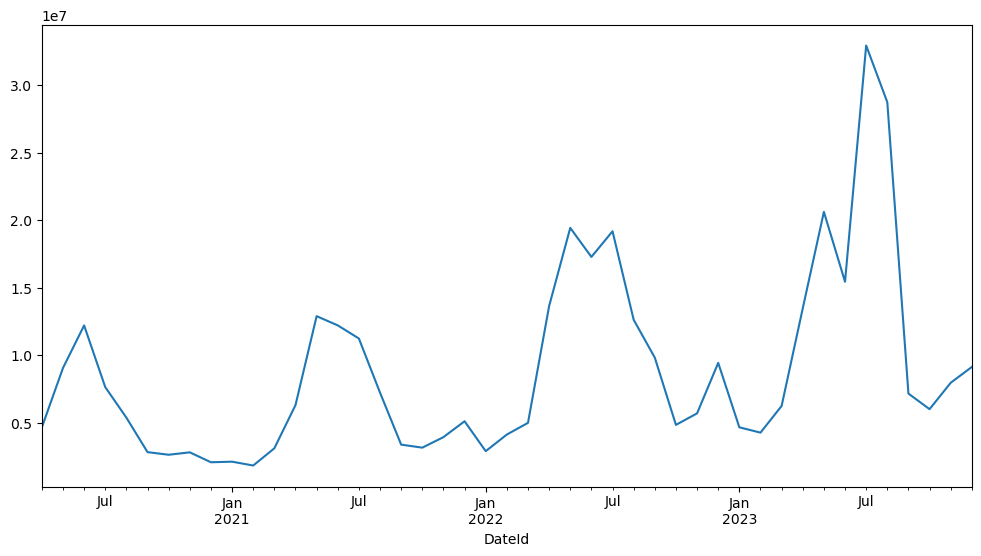

In [282]:
eligible_sales          = filtered_df.query("ProductId.isin(@eligible_products.index)")
assert                    eligible_sales.ProductId.unique().sort() == np.array(eligible_products.index).sort()

eligible_sales_by_month = eligible_sales.resample("ME")["Total"].sum()
eligible_sales_by_month.plot()

### Analyze Product (TODO)

In [54]:
#TODO : Add weighted sum for discount rate
def analyze_product(product_id):
    product_data       = df.query(f"ProductId == {product_id}")
    
    monthly_amount_sum = product_data.resample("ME").sum()["Amount"].plot()
    plt.axhline(0, color="red")

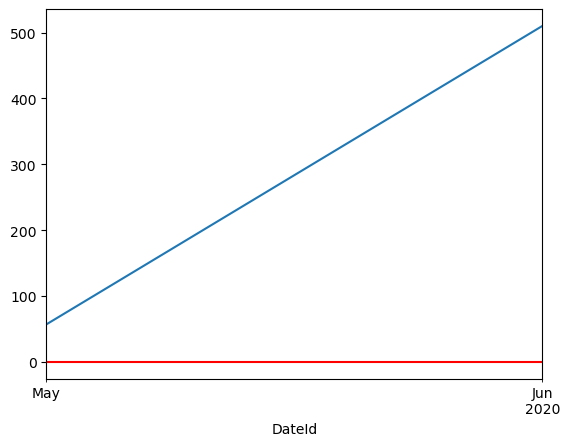

In [56]:
analyze_product(13486)

## Discount

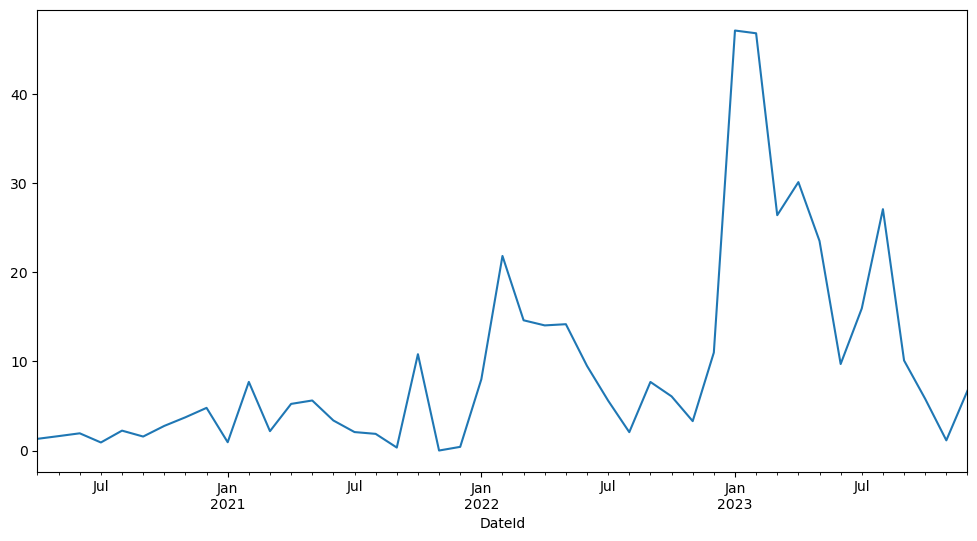

In [413]:
product = filtered_df.query("ProductId == 12558")
product.resample("ME").mean()["DiscountRate"].plot();

## Forecasting

In [414]:
from statsmodels.tsa.filters.hp_filter import hpfilter

In [791]:
# Set up product_df
product_id = 12555

product_data = df#.query(f"ProductId == {product_id}")

columns_to_sum = ["Amount", "Total"]
product_df = product_data[columns_to_sum].resample("ME").sum()

non_negative_data = product_data.query("Amount > 0")
print(f"{round(len(non_negative_data) / len(product_data), 2)} of the product data is positive")

non_negative_data["WeightedDiscount"] = non_negative_data["DiscountRate"] * non_negative_data["Amount"]
non_negative_aggreagated = non_negative_data.resample("ME").sum()
product_df["MeanDiscountPercent"] = non_negative_aggreagated["WeightedDiscount"] / (non_negative_aggreagated["Amount"] * 100)

product_df.loc[product_df["Amount"] < 0, ["Amount", "Total"]] = 1

product_df.head()

0.82 of the product data is positive


/tmp/ipykernel_224081/1227543604.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_negative_data["WeightedDiscount"] = non_negative_data["DiscountRate"] * non_negative_data["Amount"]


,Amount,Total,MeanDiscountPercent
DateId,,,
2020-04-30,524721,8881849.07,0.003203
2020-05-31,741194,12196109.37,0.014372
2020-06-30,1554857,22990487.63,0.036758
2020-07-31,1073270,15890293.44,0.030352
2020-08-31,610294,7969119.30,0.037994


In [615]:
product_df["trend"], product_df["cycle"] = hpfilter(product_df["Amount"], lamb=1600)
product_df["hp_sum"] = product_df.trend + product_df.cycle

<Axes: xlabel='DateId'>

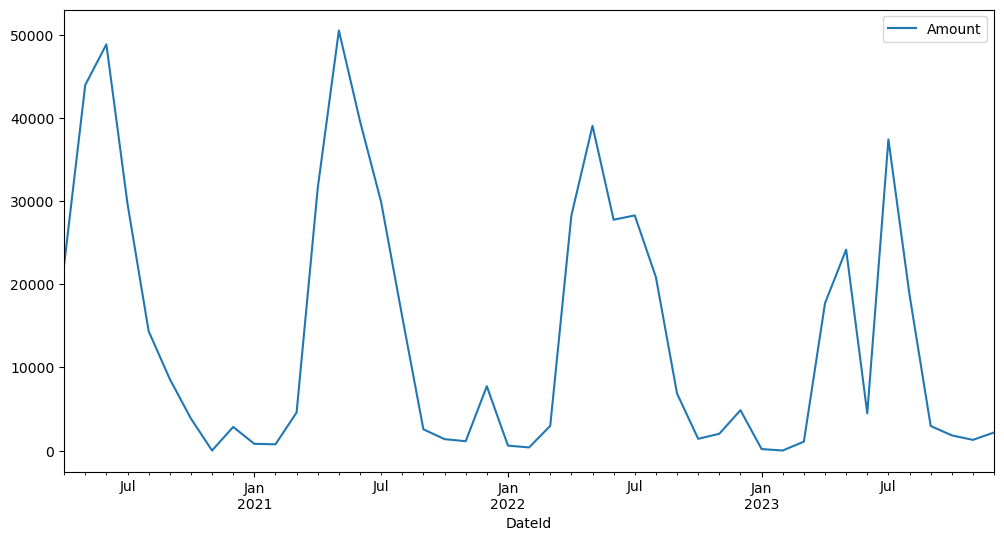

In [616]:
product_df[["Amount"]].plot()

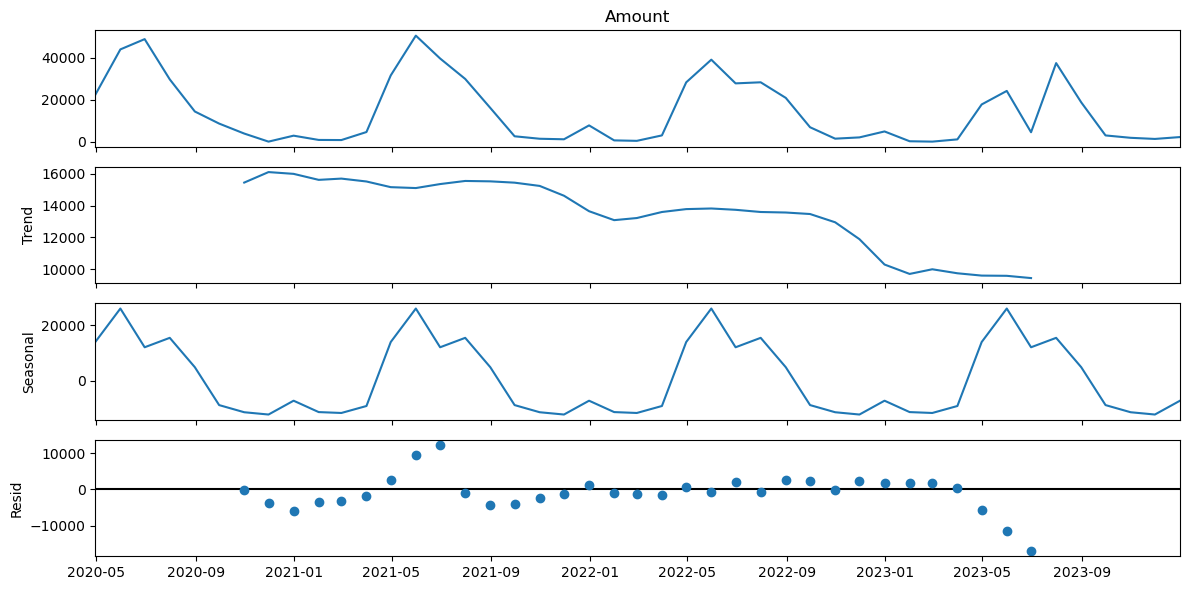

In [617]:
result = seasonal_decompose(product_df["Amount"], model="add")
result.plot();

<Axes: xlabel='DateId'>

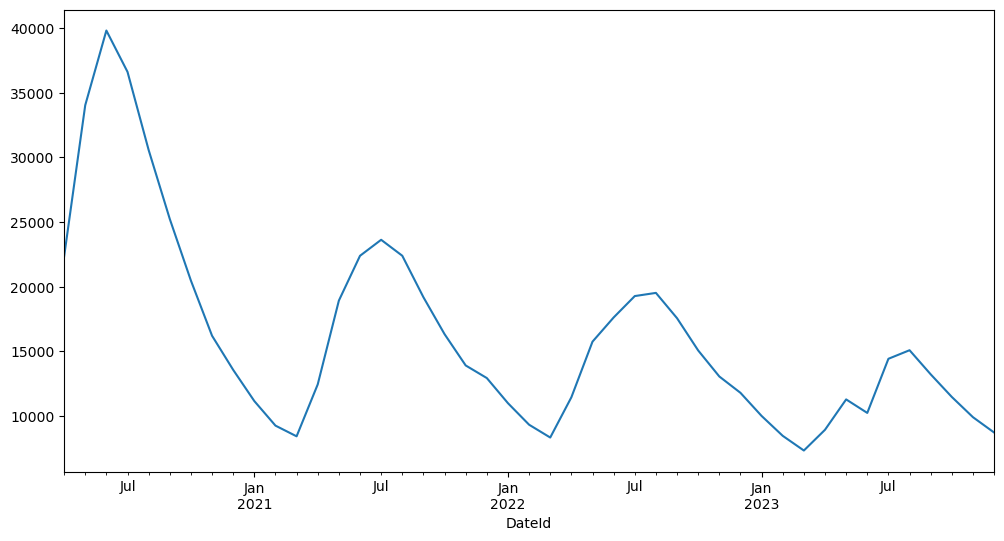

In [618]:
product_df["Amount"].ewm(span=12).mean().plot()

In [619]:
# Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [620]:
product_df["DES_12"] = ExponentialSmoothing(product_df["Amount"], trend="add").fit().fittedvalues.shift(-1)

/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


<Axes: xlabel='DateId'>

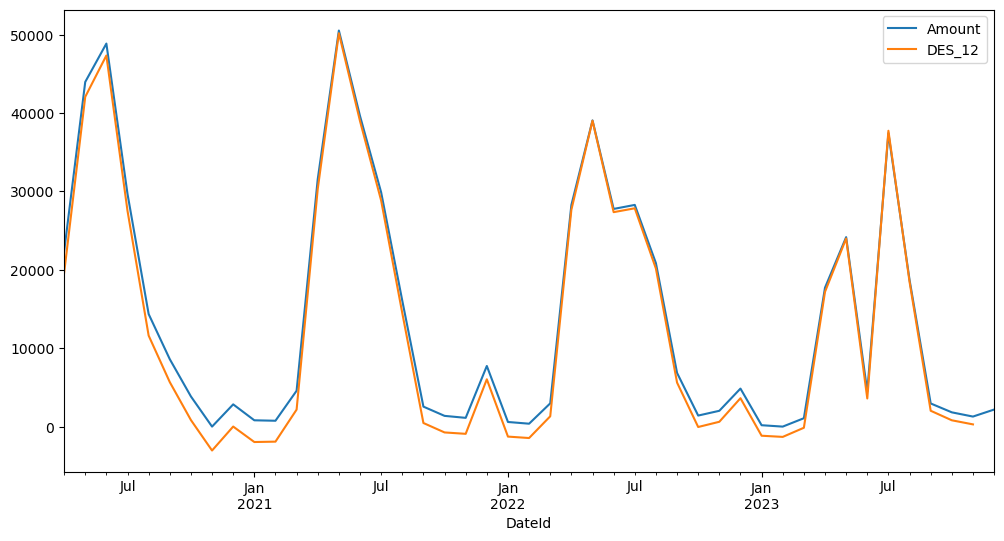

In [621]:
product_df[["Amount", "DES_12"]].plot()

In [622]:
product_df["TES_12"] = ExponentialSmoothing(
    product_df["Amount"], 
    trend="add",
    seasonal = "add",
    seasonal_periods = 12).fit().fittedvalues

/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


<Axes: xlabel='DateId'>

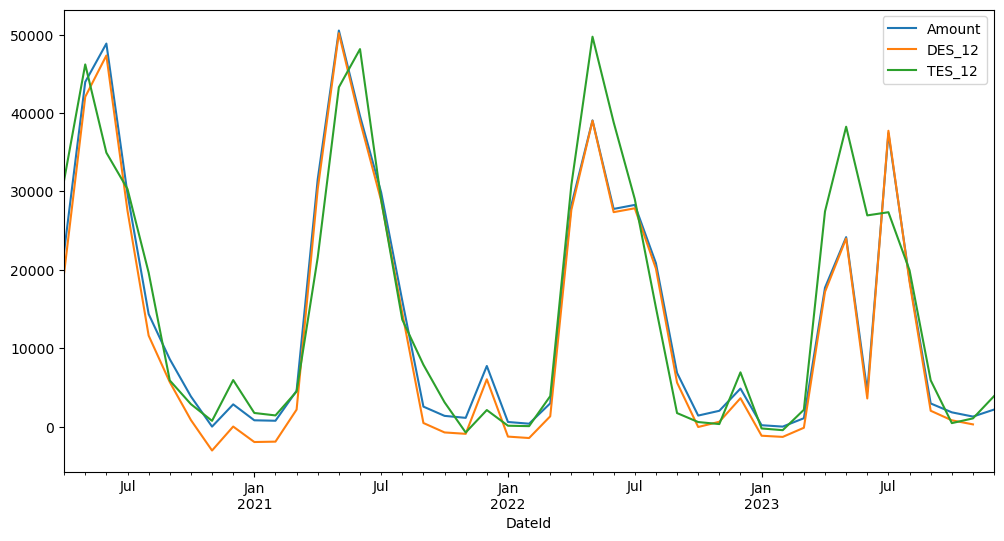

In [623]:
product_df[["Amount", "DES_12", "TES_12"]].plot()

/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


<Axes: xlabel='DateId'>

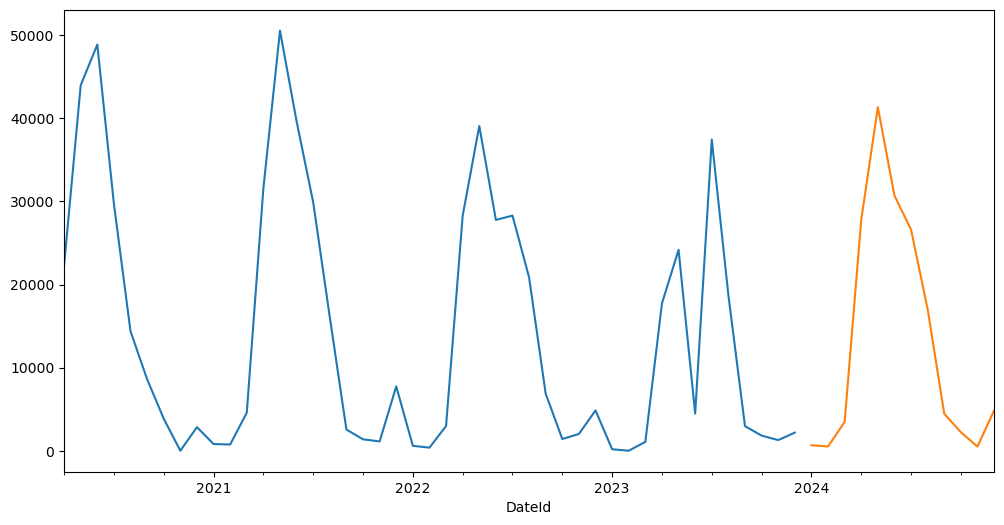

In [625]:
model = ExponentialSmoothing(
    product_df["Amount"], 
    trend="mul",
    seasonal = "mul",
    seasonal_periods = 12).fit()

product_df["Amount"].plot()
model.forecast(12).plot()

In [626]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [627]:
np.sqrt(mean_squared_error(product_df.Amount, product_df["TES_12"]))

6420.996624198263

In [628]:
product_df.Amount.std()

15429.89900390495

In [668]:
from statsmodels.tsa.ar_model import AutoReg, AutoRegResults, ar_select_order

In [696]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

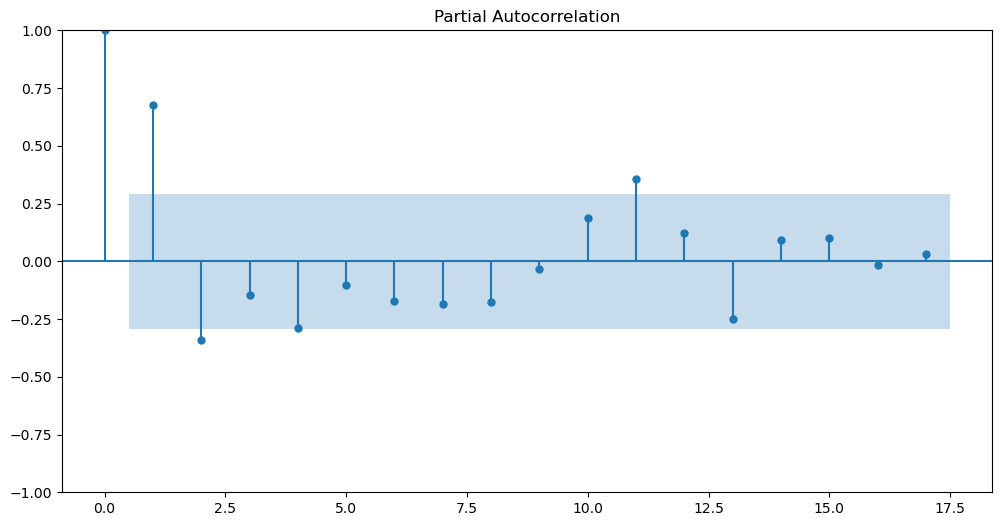

In [698]:
plot_pacf(product_df["Amount"]);

<Axes: xlabel='DateId'>

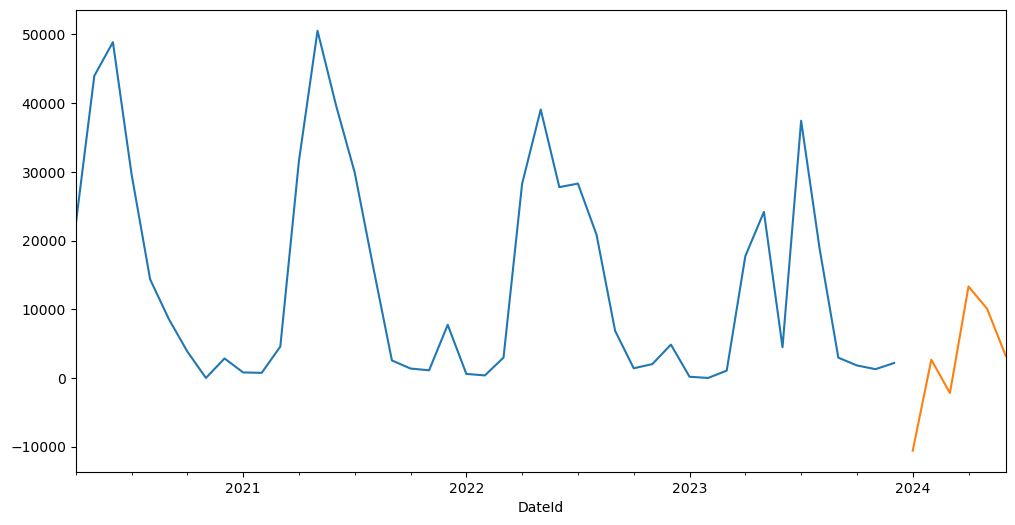

In [690]:
model = AutoReg(product_df["Amount"], lags=12).fit()
length = len(product_df["Amount"])
product_df["Amount"].plot()
model.forecast(6).plot()

In [629]:
from pandas.plotting import lag_plot

<Axes: xlabel='y(t)', ylabel='y(t + 12)'>

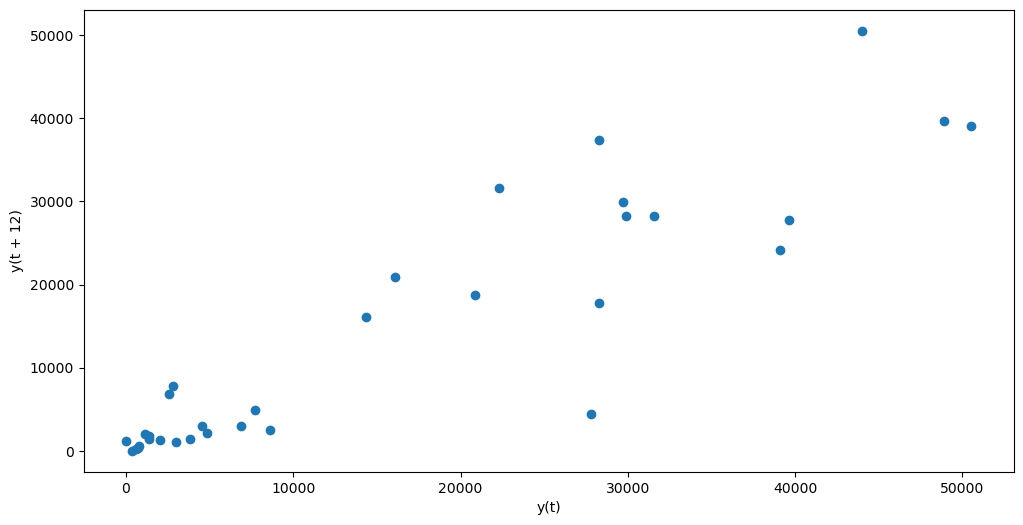

In [630]:
lag_plot(product_df["Amount"], lag=12)

In [631]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

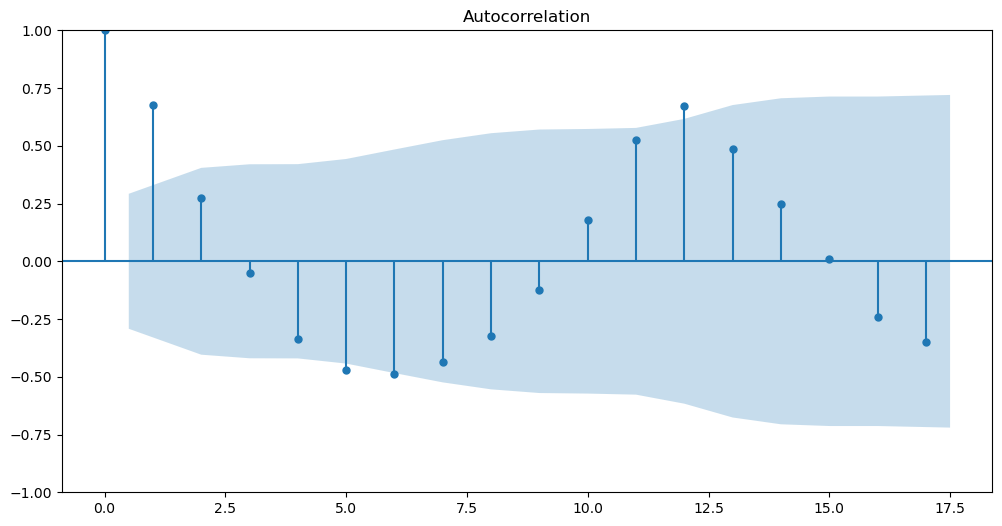

In [632]:
plot_acf(product_df["Amount"]);

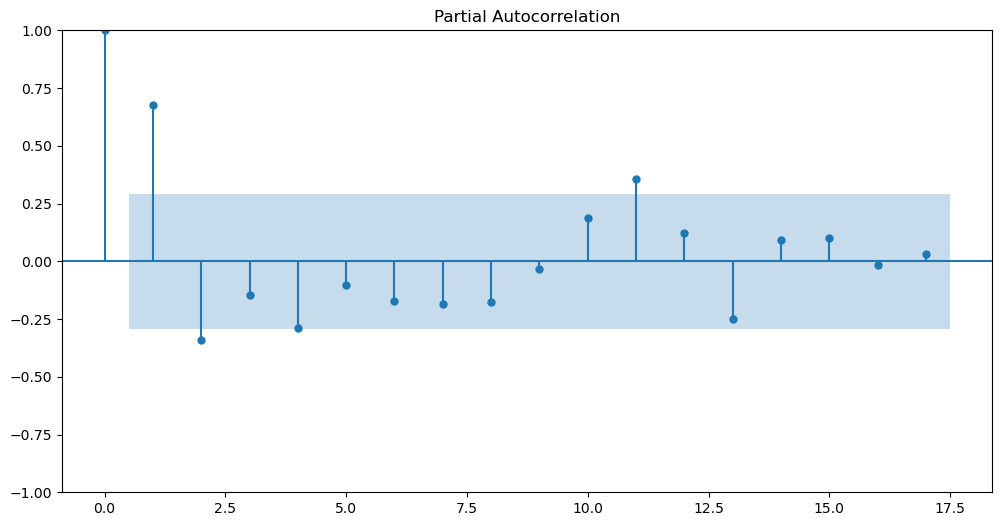

In [633]:
plot_pacf(product_df["Amount"]);

In [640]:
# Causality Test

from statsmodels.tsa.stattools import grangercausalitytests

In [643]:
grangercausalitytests(product_df[["Amount", "MeanDiscountPercent"]], maxlag=3);


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0632  , p=0.8028  , df_denom=41, df_num=1
ssr based chi2 test:   chi2=0.0678  , p=0.7946  , df=1
likelihood ratio test: chi2=0.0677  , p=0.7947  , df=1
parameter F test:         F=0.0632  , p=0.8028  , df_denom=41, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.4375  , p=0.2501  , df_denom=38, df_num=2
ssr based chi2 test:   chi2=3.2533  , p=0.1966  , df=2
likelihood ratio test: chi2=3.1361  , p=0.2084  , df=2
parameter F test:         F=1.4375  , p=0.2501  , df_denom=38, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.1685  , p=0.0018  , df_denom=35, df_num=3
ssr based chi2 test:   chi2=22.2064 , p=0.0001  , df=3
likelihood ratio test: chi2=17.8262 , p=0.0005  , df=3
parameter F test:         F=6.1685  , p=0.0018  , df_denom=35, df_num=3


In [664]:
from statsmodels.graphics.tsaplots import month_plot, quarter_plot

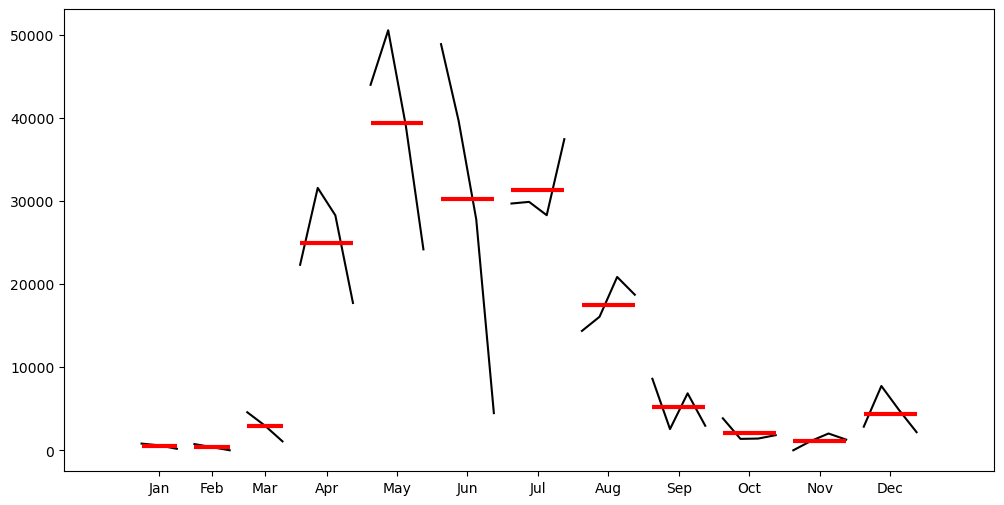

In [665]:
month_plot(product_df["Amount"]);

In [759]:
from pmdarima import auto_arima

In [792]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [793]:
auto_arima(product_df["Amount"], seasonal=True, m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   45
Model:             SARIMAX(1, 0, 1)x(1, 0, [], 12)   Log Likelihood                -622.553
Date:                             Sat, 03 Feb 2024   AIC                           1255.107
Time:                                     00:55:16   BIC                           1264.140
Sample:                                 04-30-2020   HQIC                          1258.474
                                      - 12-31-2023                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2.346e+05   1.73e+05      1.354      0.176   -1.05e+05    5.74e+05
ar.L1          0.2269      0.389      0.583      0.560      -0.536       0.990
ma.L1          0.3503      0.435      0.805      0.421      -0.502       1.203
ar.S.L12       0.4776      0.170      2.810      0.005       0.145       0.811
sigma2       6.16e+10      0.201   3.07e+11      0.000    6.16e+10    6.16e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):                 9.39
Prob(Q):                              0.70   Prob(JB):                         0.01
Heteroskedasticity (H):               0.87   Skew:                             0.94
Prob(H) (two-sided):                  0.79   Kurtosis:                         4.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.33e+27. Standard errors may be unstable.
"""

In [809]:
train = product_df[:"2023-06-01"]
test  = product_df["2023-06-01":"2023-08-01"]

In [810]:
model = SARIMAX(train["Amount"], order=(1, 0, 1), seasonal_order=(1, 0, [], 12)).fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.39898D+01    |proj g|=  2.82031D-01

At iterate    5    f=  1.38651D+01    |proj g|=  8.04467D-03

At iterate   10    f=  1.38650D+01    |proj g|=  4.56531D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     15      1     0     0   5.702D-06   1.386D+01
  F =   13.864985527002435     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


<Axes: xlabel='DateId'>

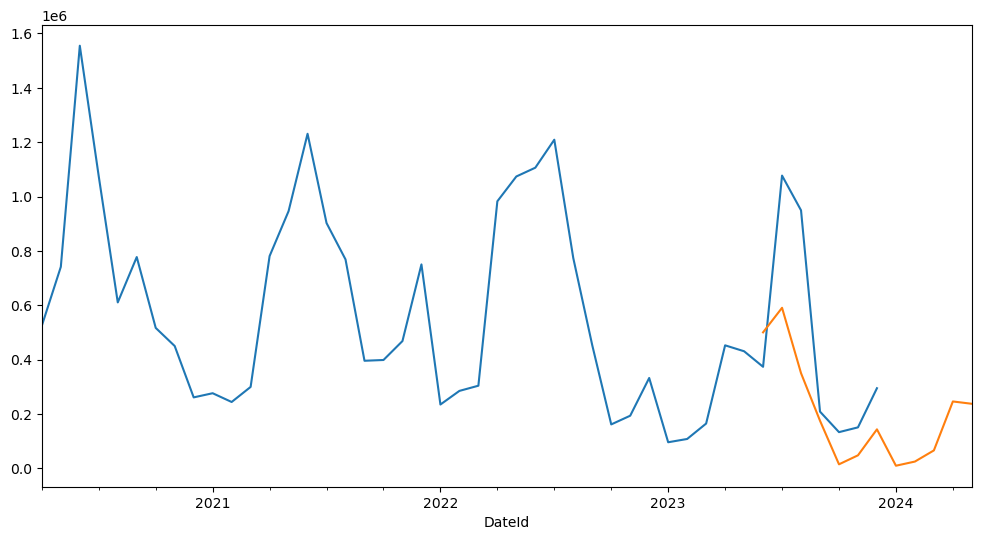

In [815]:
#df["Amount"].resample("ME").sum().plot()
product_df["Amount"].plot()
predicted = model.forecast(12)
predicted.plot()
#(product_df["MeanDiscountPercent"]*10000000).plot()

In [812]:
test.Amount

DateId
2023-06-30     373326
2023-07-31    1076939
Freq: ME, Name: Amount, dtype: int64

In [813]:
predicted

2023-06-30    500077.187022
2023-07-31    590462.973561
Freq: ME, Name: predicted_mean, dtype: float64

In [814]:
mean_absolute_error(test["Amount"], predicted) / test["Amount"].mean()

0.42283804233136013